In [1]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
from tslearn import barycenters

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [9]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load in pyspi results
# for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
for pyspi_res_file in glob(f"{pyspi_res_path_averaged}/*pyspi*.csv"):
    pyspi_res_averaged = pd.read_csv(pyspi_res_file)
    all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)
    
# Concatenate pyspi results
all_barycenter_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list).query("SPI.str.contains('bary')")

# Specifically filter to bary_euclidean
bary_sq_euclidean_res_averaged_epochs = all_barycenter_res_averaged_epochs.query("SPI.str.contains('bary-sq_euclidean')")

# Case study: Barycenter visualization for two subjects

### Visualizing the squared barycenter with Euclidean distance [mean] SPI

In [ ]:
# Extract the time series for this subject
sub_CB038_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB038_ses-1_meg_1000ms_all_time_series.csv")
sub_CB038_time_series_of_interest = sub_CB038_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'False'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with Euclidean distance

# False stimuli
sub_CB038_CS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").Category_Selective.values
sub_CB038_IPS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").IPS.values
# z-score the time series
sub_CB038_CS_false = (sub_CB038_CS_false - sub_CB038_CS_false.mean()) / sub_CB038_CS_false.std()
sub_CB038_IPS_false = (sub_CB038_IPS_false - sub_CB038_IPS_false.mean()) / sub_CB038_IPS_false.std()
sub_CB038_false_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_false, sub_CB038_IPS_false])

# Face stimuli
sub_CB038_CS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB038_IPS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").IPS.values
# z-score the time series
sub_CB038_CS_face = (sub_CB038_CS_face - sub_CB038_CS_face.mean()) / sub_CB038_CS_face.std()
sub_CB038_IPS_face = (sub_CB038_IPS_face - sub_CB038_IPS_face.mean()) / sub_CB038_IPS_face.std()
sub_CB038_face_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_face, sub_CB038_IPS_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB038_false_barycenter = sub_CB038_false_barycenter.flatten()
sub_CB038_face_barycenter = sub_CB038_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB038_false_barycenter_sq = np.square(sub_CB038_false_barycenter)
sub_CB038_face_barycenter_sq = np.square(sub_CB038_face_barycenter)

# Print the mean squared barycenter for face vs false
print("Mean squared barycenter for face stimuli: ", np.mean(sub_CB038_face_barycenter_sq))
print("Mean squared barycenter for false stimuli: ", np.mean(sub_CB038_false_barycenter_sq))

Mean squared barycenter for face stimuli:  0.2970573114719432
Mean squared barycenter for false stimuli:  0.5944635036343306


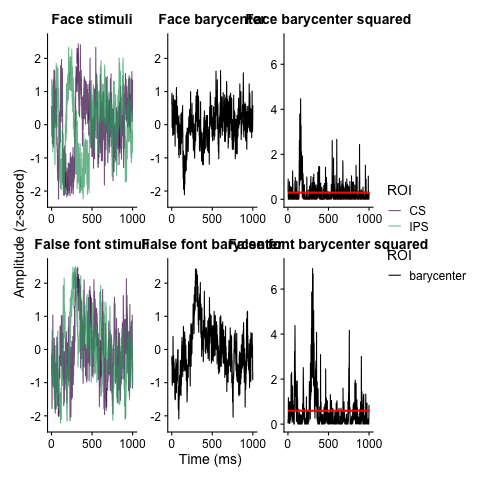

In [ ]:
%%R -i sub_CB038_false_barycenter,sub_CB038_face_barycenter,sub_CB038_false_barycenter_sq,sub_CB038_face_barycenter_sq,sub_CB038_CS_face,sub_CB038_IPS_face,sub_CB038_CS_false,sub_CB038_IPS_false

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), IPS = sub_CB038_IPS_face,
           CS = sub_CB038_CS_face) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB038_face_barycenter), 
                                value = sub_CB038_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), 
                                value = sub_CB038_face_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red") +
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for false
false_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
IPS = sub_CB038_IPS_false,
           CS = sub_CB038_CS_false) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("False font stimuli")

# Plot barycenter only for false
false_barycenter_p <- data.frame(times=1:length(sub_CB038_false_barycenter),
                                value = sub_CB038_false_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black",
                                "IPS" = "#2ea16b",
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("False font barycenter")

# Plot barycenter squared only for false
false_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
                                value = sub_CB038_false_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red")+
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("False font barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       false_barycenter_ts_p, false_barycenter_p, false_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

# ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_false_font_CB038.svg", width=7, height=4, units='in', dpi=300)

### Visualize an example for max of squared barycenter with soft-DTW geometry between the CS and IPS regions

In [ ]:
# Extract the time series for this subject
sub_CB073_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB073_ses-1_meg_1000ms_all_time_series.csv")
sub_CB073_time_series_of_interest = sub_CB073_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'object'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with expectation maximisation (dtw)

# object stimuli stimuli
sub_CB073_CS_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Category_Selective.values
sub_CB073_PFC_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_object = (sub_CB073_CS_object - sub_CB073_CS_object.mean()) / sub_CB073_CS_object.std()
sub_CB073_PFC_object = (sub_CB073_PFC_object - sub_CB073_PFC_object.mean()) / sub_CB073_PFC_object.std()
sub_CB073_object_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_object, sub_CB073_PFC_object])

# Face stimuli
sub_CB073_CS_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB073_PFC_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_face = (sub_CB073_CS_face - sub_CB073_CS_face.mean()) / sub_CB073_CS_face.std()
sub_CB073_PFC_face = (sub_CB073_PFC_face - sub_CB073_PFC_face.mean()) / sub_CB073_PFC_face.std()
sub_CB073_face_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_face, sub_CB073_PFC_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB073_object_barycenter = sub_CB073_object_barycenter.flatten()
sub_CB073_face_barycenter = sub_CB073_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB073_object_barycenter_sq = np.square(sub_CB073_object_barycenter)
sub_CB073_face_barycenter_sq = np.square(sub_CB073_face_barycenter)

# Print the mean squared barycenter for face vs object
print("Max squared barycenter for face stimuli: ", np.max(sub_CB073_face_barycenter_sq))
print("Max squared barycenter for object stimuli: ", np.max(sub_CB073_object_barycenter_sq))

Max squared barycenter for face stimuli:  11.171084959146794
Max squared barycenter for object stimuli:  7.485024083063338


In [ ]:
%%R -i sub_CB073_object_barycenter,sub_CB073_face_barycenter,sub_CB073_object_barycenter_sq,sub_CB073_face_barycenter_sq,sub_CB073_CS_face,sub_CB073_PFC_face,sub_CB073_CS_object,sub_CB073_PFC_object

linewidth=0.2
PFC_color="#cdb902"
CS_color="#410151"
ts_range=c(-4, 4)
squared_range=c(0, 12)

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), PFC = sub_CB073_PFC_face,
           CS = sub_CB073_CS_face) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB073_face_barycenter), 
                                value = sub_CB073_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=0.5) +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), 
                                value = sub_CB073_face_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for object
object_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
PFC = sub_CB073_PFC_object,
           CS = sub_CB073_CS_object) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Object stimuli")

# Plot barycenter only for object
object_barycenter_p <- data.frame(times=1:length(sub_CB073_object_barycenter),
                                value = sub_CB073_object_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=linewidth) +
    ggtitle("Object barycenter")

# Plot barycenter squared only for object
object_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
                                value = sub_CB073_object_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Object barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       object_barycenter_ts_p, object_barycenter_p, object_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_object_CB073.svg", width=7, height=4, units='in', dpi=300)

# Zooming out to examine general trends in barycenter

### Across all stimulus types, how do the barycenter mean/max compare for the different geometries? (Euclidean, DTW, SGD-DTW, soft-DTW)

In [10]:
%%R -i all_barycenter_res_averaged_epochs

for (this_stim in unique(all_barycenter_res_averaged_epochs$stimulus_type)) {
       all_barycenter_res_averaged_epochs %>% 
              filter(stimulus_type==this_stim & relevance_type == "Relevant non-target") %>%
              mutate(SPI_stat = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
              mutate(SPI_base = gsub("_mean|_max", "", SPI)) %>% 
              mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
              filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
              mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
              mutate(SPI_base = factor(SPI_base, levels=c("bary_euclidean", "bary_dtw", 
                                                        "bary_softdtw", "bary_sgddtw", 
                                                        "bary-sq_euclidean", "bary-sq_dtw", 
                                                        "bary-sq_softdtw","bary-sq_sgddtw"))) %>%
              mutate(SPI__stimulus = glue("{SPI_stat}__{stimulus_presentation}")) %>%
              mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off"))) %>%
              ggplot(data=., mapping=aes(x=SPI__stimulus, y=value, group=subject_ID, color=meta_ROI_pair)) +
              geom_line(alpha=0.4, linewidth=0.3) +
              scale_color_manual(values=c("CS <-> VIS"="#e96893", "CS <-> PFC"="#5b8c00")) +
              facet_grid(SPI_base ~ meta_ROI_pair, scales="free") +
              ggtitle(glue("Stimulus: {this_stim}")) +
              ylab("Barycenter SPI value") +
              xlab("SPI and stimulus presentation") +
              labs(color="") +
              theme(legend.position = "bottom",
                     strip.background = element_blank(),
                     axis.text.x = element_text(angle=30, hjust=1),
                     strip.text.x = element_text(face='bold'),
                     strip.text.y = element_text(angle=0, face='bold')) 
       ggsave(glue("../plots/modeling/Barycenters_mean_max_{this_stim}.png"), width=7, height=10, units='in', dpi=300)
}



/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


### How does the Euclidean barycenter mean/max compare at onset and offset for different region pairs?

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


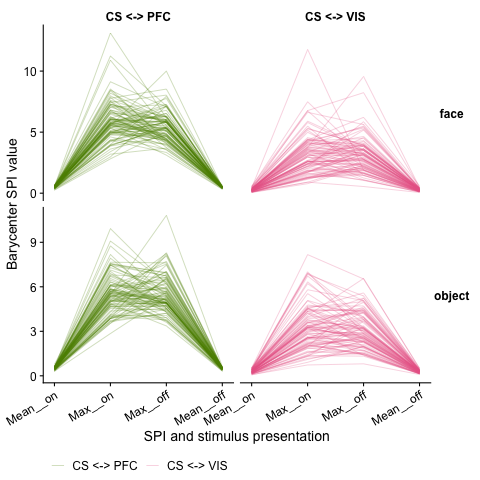

In [11]:
%%R -i bary_sq_euclidean_res_averaged_epochs

bary_sq_euclidean_res_averaged_epochs %>% 
        filter(stimulus_type %in% c('face', 'object') & relevance_type == "Relevant non-target") %>%
        mutate(SPI = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
        mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
        filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
        mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
        mutate(SPI__stimulus = glue("{SPI}__{stimulus_presentation}")) %>%
        mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off")),
               stimulus_type = factor(stimulus_type, levels=c("face", "object"))) %>%
        ggplot(data=., mapping=aes(x=SPI__stimulus, y=value, group=subject_ID, color=meta_ROI_pair)) +
        geom_line(alpha=0.4, linewidth=0.3) +
        scale_color_manual(values=c("CS <-> VIS"="#e96893", "CS <-> PFC"="#5b8c00")) +
        facet_grid(stimulus_type ~ meta_ROI_pair, scales="free") +
        scale_x_discrete(expand=c(0.05, 0.05)) +
        ylab("Barycenter SPI value") +
        xlab("SPI and stimulus presentation") +
        labs(color="") +
        theme(legend.position = "bottom",
                strip.background = element_blank(),
                axis.text.x = element_text(angle=30, hjust=1),
                strip.text.x = element_text(face='bold'),
                strip.text.y = element_text(angle=0, face='bold')) 
# ggsave(glue("../plots/modeling/Barycenters_Sq_Euclidean_mean_max_across_stimuli.svg"), width=6, height=3.5, units='in', dpi=300)

In [12]:
%%R -i all_barycenter_res_averaged_epochs -o test_df

geom <- "euclidean" 
bary_type = "squared" 
bary_type_label = ifelse(bary_type=="squared", "-sq", "")
this_rel = "Irrelevant"
relevance_label = ifelse(this_rel=="Relevant non-target", "Relevant", "Irrelevant")

test_df <- all_barycenter_res_averaged_epochs %>% 
                filter(str_detect(SPI, glue("bary{bary_type_label}_{geom}")),
                    relevance_type == this_rel,
                    stimulus_type %in% c('face', 'object')) %>%
                mutate(SPI = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
                mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
                filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
                mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
                mutate(SPI__stimulus = glue("{SPI}__{stimulus_presentation}")) %>%
                mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off")),
                    stimulus_type = factor(stimulus_type, levels=c("face", "object")))

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [14]:
%%R -i all_barycenter_res_averaged_epochs

for (geom in c("euclidean", "dtw")) {
    for (bary_type in c("original", "squared")) {
        bary_type_label = ifelse(bary_type=="squared", "-sq", "")
        for (this_rel in c("Relevant non-target", "Irrelevant")) {
            relevance_label = ifelse(this_rel=="Relevant non-target", "Relevant", "Irrelevant")
            print(glue("Now plotting {geom} barycenter{bary_type_label}, {relevance_label}"))
            
            all_barycenter_res_averaged_epochs %>% 
                filter(str_detect(SPI, glue("bary{bary_type_label}_{geom}")),
                    relevance_type == this_rel,
                    stimulus_type %in% c('face', 'object')) %>%
                mutate(SPI = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
                mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
                filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
                mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
                mutate(SPI__stimulus = glue("{SPI}__{stimulus_presentation}")) %>%
                mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off")),
                    stimulus_type = factor(stimulus_type, levels=c("face", "object"))) %>%
                ggplot(data=., mapping=aes(x=SPI__stimulus, y=value, group=subject_ID, color=meta_ROI_pair)) +
                geom_line(alpha=0.4, linewidth=0.3) +
                scale_color_manual(values=c("CS <-> VIS"="#e96893", "CS <-> PFC"="#5b8c00")) +
                facet_grid(stimulus_type ~ meta_ROI_pair, scales="fixed") +
                scale_x_discrete(expand=c(0.05, 0.05)) +
                ylab("Barycenter SPI value") +
                xlab("SPI and stimulus presentation") +
                ggtitle(glue("{geom} barycenter{bary_type_label}")) +
                labs(color="") +
                theme(legend.position = "bottom",
                        strip.background = element_blank(),
                        plot.title = element_text(hjust = 0.5, size=14),
                        axis.text.x = element_text(angle=30, hjust=1),
                        strip.text.x = element_text(face='bold'),
                        strip.text.y = element_text(angle=0, face='bold')) 
            ggsave(glue("../plots/modeling/Barycenters{bary_type_label}_{geom}_{relevance_label}_mean_max_across_stimuli.svg"), width=6, height=3.5, units='in', dpi=300)
        }
    }
}

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Now plotting euclidean barycenter, Relevant
Now plotting euclidean barycenter, Irrelevant
Now plotting euclidean barycenter-sq, Relevant
Now plotting euclidean barycenter-sq, Irrelevant
Now plotting dtw barycenter, Relevant
Now plotting dtw barycenter, Irrelevant
Now plotting dtw barycenter-sq, Relevant
Now plotting dtw barycenter-sq, Irrelevant


### How does the mean vs. max compare in classification performance?

In [15]:
# Load classification res -- update to where you have stored your classification results
classification_res_path = f"{deriv_dir}/classification_results/across_participants"
face_non_face_str = "('face', 'non-face')"
barycenter_averaged_stimulus_type_LR_classification_res = (pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_Logistic_Regression_classification_results.csv")
                                                .query("SPI.str.contains('bary') & stimulus_combo != @face_non_face_str")
)

In [16]:
%%R -i barycenter_averaged_stimulus_type_LR_classification_res -o barycenter_averaged_stimulus_type_LR_classification_res

barycenter_averaged_stimulus_type_LR_classification_res <- barycenter_averaged_stimulus_type_LR_classification_res %>%
    rowwise() %>%
    mutate(Barycenter_Type = ifelse(str_detect(SPI, "-sq"), "squared", "original"),
           Stat = ifelse(str_detect(SPI, "_max"), "max", "mean"),
           Geometry = str_split(SPI, "_")[[1]][2]) 

In [17]:
barycenter_averaged_stimulus_type_LR_classification_res.head()

,SPI,meta_ROI_from,meta_ROI_to,relevance_type,stimulus_presentation,stimulus_combo,accuracy,balanced_accuracy,AUC,Barycenter_Type,Stat,Geometry
1,bary_euclidean_max,Category_Selective,IPS,Relevant-non-target,on,"('false', 'face')",0.490556,0.490556,0.487679,original,max,euclidean
2,bary_euclidean_max,Category_Selective,IPS,Relevant-non-target,on,"('false', 'letter')",0.500000,0.500000,0.500000,original,max,euclidean
3,bary_euclidean_max,Category_Selective,IPS,Relevant-non-target,on,"('false', 'object')",0.500000,0.500000,0.515840,original,max,euclidean
4,bary_euclidean_max,Category_Selective,IPS,Relevant-non-target,on,"('face', 'letter')",0.490556,0.490556,0.495185,original,max,euclidean
5,bary_euclidean_max,Category_Selective,IPS,Relevant-non-target,on,"('face', 'object')",0.500000,0.500000,0.459877,original,max,euclidean


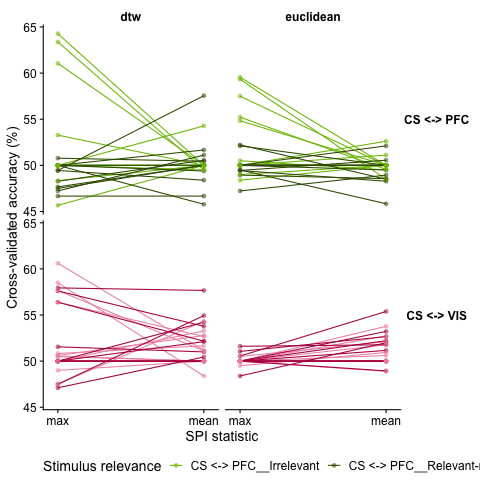

In [38]:
%%R -i barycenter_averaged_stimulus_type_LR_classification_res

barycenter_averaged_stimulus_type_LR_classification_res %>%
    filter(Barycenter_Type == "squared", Geometry %in% c("euclidean", "dtw")) %>%
    filter(meta_ROI_from == "Category_Selective", meta_ROI_to %in% c("V1_V2", "Prefrontal_Cortex")) %>%
    mutate(comparison_group = glue("{meta_ROI_from}__{meta_ROI_to}__{relevance_type}__{stimulus_presentation}__{stimulus_combo}"),
           meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
    mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
    mutate(ROI__Rel = glue("{meta_ROI_pair}__{relevance_type}")) %>%
    ggplot(data=., mapping=aes(x=Stat, y=100*accuracy, group=comparison_group, color=ROI__Rel)) +
    geom_line() +
    geom_point(alpha=0.5) +
    facet_grid(meta_ROI_pair ~ Geometry, scales="fixed") +
    scale_x_discrete(expand=c(0.05, 0.05)) +
    scale_color_manual(values = c("CS <-> VIS__Relevant-non-target" = "#b61b4f", "CS <-> PFC__Relevant-non-target" = "#3a5900",
                                   "CS <-> VIS__Irrelevant" = "#f095b3", "CS <-> PFC__Irrelevant" = "#7cbf00")) +
    labs(color = "Stimulus relevance") +
    ylab("Cross-validated accuracy (%)") +
    xlab("SPI statistic") +
    theme(legend.position = "bottom",
          strip.background = element_blank(),
          strip.text.x = element_text(face='bold'),
          strip.text.y = element_text(angle=0, face='bold'))
# ggsave(glue("../plots/modeling/Barycenters_Sq_Euclidean_and_DTW_mean_max_performance_across_stimuli.svg"), width=6, height=4.5, units='in', dpi=300)

# What about the timing of the barycenter max between each ROI--ROI pair?

In [54]:
# Initialize list for pyspi results
all_time_resolved_barycenter_res_list = []

# Load in time-resolved barycenter results
for barycenter_time_res_file in glob(f"{pyspi_res_path_averaged}/*barycenter*.csv"):
    barycenter_time_resolved_res = pd.read_csv(barycenter_time_res_file)
    all_time_resolved_barycenter_res_list.append(barycenter_time_resolved_res)

# Concatenate pyspi results
all_time_resolved_barycenter_res = pd.concat(all_time_resolved_barycenter_res_list)

all_time_resolved_barycenter_res.head()

,Presentation,Barycenter_Type,Mean,Max,Max_Time,Subject,Region,Relevance,Stimulus,Barycenter_Method
0,Onset,Original,-2.839332e-17,2.314943,563.0,sub-CB049,CS_PFC,Irrelevant,False,euclidean
1,Offset,Original,0.000000e+00,2.280326,785.0,sub-CB049,CS_PFC,Irrelevant,False,euclidean
2,Onset,Squared,5.649296e-01,8.072949,972.0,sub-CB049,CS_PFC,Irrelevant,False,euclidean
3,Offset,Squared,5.647868e-01,5.199888,785.0,sub-CB049,CS_PFC,Irrelevant,False,euclidean
4,Onset_First500,Original,1.861490e-01,2.004739,124.0,sub-CB049,CS_PFC,Irrelevant,False,euclidean


In [62]:
%%R -i all_time_resolved_barycenter_res

all_time_resolved_barycenter_res %>% 
    filter(Relevance %in% c("Irrelevant", "Relevant non-target")) %>%
    filter(Presentation=="Onset", Barycenter_Type=="Squared") %>% 
    mutate(Region_Pair = ifelse(Region=="CS_PFC", "CS <-> PFC", "CS <-> VIS"),
           Relevance = factor(Relevance, levels=c("Relevant non-target", "Irrelevant"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=Region_Pair)) +
    scale_fill_manual(values=c("CS <-> VIS" = "#e96893", "CS <-> PFC" = "#5b8c00"))  +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.5) +
    facet_grid(Relevance ~ Barycenter_Method, scales="free") +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))
ggsave(glue("../plots/modeling/Barycenters_Sq_Euclidean_and_DTW_max_timing_across_stimuli.svg"), width=6, height=4, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
